El servicio de venta de autos usados Rusty Bargain está desarrollando una aplicación para atraer nuevos clientes. Gracias a esa app, puedes averiguar rápidamente el valor de mercado de tu coche. Tienes acceso al historial: especificaciones técnicas, versiones de equipamiento y precios. Tienes que crear un modelo que determine el valor de mercado.
A Rusty Bargain le interesa:
- la calidad de la predicción;
- la velocidad de la predicción;
- el tiempo requerido para el entrenamiento

## Preparación de datos

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import lightgbm as lgb
from catboost import CatBoostRegressor
from xgboost import XGBRegressor

In [2]:
cardata = pd.read_csv('/datasets/car_data.csv')

<div class="alert alert-block alert-success">
<b>Comentario del revisor</b> <a class="tocSkip"></a>
    
Buen trabajo con la importación de datos y de librerías.
</div>

In [3]:
cardata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Mileage            354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

En la información general podemos observar que hay datos faltantes en algunas columnas. A continuación se realizará un análisis del porcentaje de faltantes.

In [4]:
# primero pasar a minusculas las columnas
cardata.columns = cardata.columns.str.lower()

# Convertir las columnas de tiempo a marcas de tiempo
cardata['datecrawled'] = pd.to_datetime(
    cardata['datecrawled'], format='%d/%m/%Y %H:%M')
cardata['datecreated'] = pd.to_datetime(
    cardata['datecreated'], format='%d/%m/%Y %H:%M')
cardata['lastseen'] = pd.to_datetime(
    cardata['lastseen'], format='%d/%m/%Y %H:%M')

# Extraer características relevantes de las fechas y horas
cardata['datecrawled_year'] = cardata['datecrawled'].dt.year
cardata['datecrawled_month'] = cardata['datecrawled'].dt.month
cardata['datecrawled_day'] = cardata['datecrawled'].dt.day
cardata['datecrawled_hour'] = cardata['datecrawled'].dt.hour

cardata['datecreated_year'] = cardata['datecreated'].dt.year
cardata['datecreated_month'] = cardata['datecreated'].dt.month
cardata['datecreated_day'] = cardata['datecreated'].dt.day
cardata['datecreated_hour'] = cardata['datecreated'].dt.hour

cardata['lastseen_year'] = cardata['lastseen'].dt.year
cardata['lastseen_month'] = cardata['lastseen'].dt.month
cardata['lastseen_day'] = cardata['lastseen'].dt.day
cardata['lastseen_hour'] = cardata['lastseen'].dt.hour


# se eliminan las columnas de tiempo originales ya que no son necesarias
cardata.drop(['datecrawled', 'datecreated', 'lastseen'], axis=1, inplace=True)


total_rows = cardata.shape[0]
null_count = cardata.isnull().sum()
null_values = (null_count/total_rows) * 100

print("Porcentaje de valores faltantes en cada columna:")

print(null_values)

Porcentaje de valores faltantes en cada columna:
price                 0.000000
vehicletype          10.579368
registrationyear      0.000000
gearbox               5.596709
power                 0.000000
model                 5.560588
mileage               0.000000
registrationmonth     0.000000
fueltype              9.282697
brand                 0.000000
notrepaired          20.079070
numberofpictures      0.000000
postalcode            0.000000
datecrawled_year      0.000000
datecrawled_month     0.000000
datecrawled_day       0.000000
datecrawled_hour      0.000000
datecreated_year      0.000000
datecreated_month     0.000000
datecreated_day       0.000000
datecreated_hour      0.000000
lastseen_year         0.000000
lastseen_month        0.000000
lastseen_day          0.000000
lastseen_hour         0.000000
dtype: float64


In [5]:
display(cardata.head())

,price,vehicletype,registrationyear,gearbox,power,model,mileage,registrationmonth,fueltype,brand,...,datecrawled_day,datecrawled_hour,datecreated_year,datecreated_month,datecreated_day,datecreated_hour,lastseen_year,lastseen_month,lastseen_day,lastseen_hour
0,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,...,24,11,2016,3,24,0,2016,4,7,3
1,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,...,24,10,2016,3,24,0,2016,4,7,1
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,...,14,12,2016,3,14,0,2016,4,5,12
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,...,17,16,2016,3,17,0,2016,3,17,17
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,...,31,17,2016,3,31,0,2016,4,6,10


Al realizar el analisis de valores ausentes podemos observar que los que los contienen son características categóricas y debido a que la naturaleza de los datos no nos permite usar media, mediana o moda ya que cambiaria el contexto y la finalidad de la información la decición que me parece mas sensata es nombrar los ausentes como otra categoria: 'unknown'. De ésta manera, los usuarios que omitan esta información recibirán una predicción de precio basado solo en los datos que se ingresan con el algoritmo entrenado para ello. 

In [6]:
cardata.fillna('Unknown', inplace=True)
cardata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 25 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              354369 non-null  int64 
 1   vehicletype        354369 non-null  object
 2   registrationyear   354369 non-null  int64 
 3   gearbox            354369 non-null  object
 4   power              354369 non-null  int64 
 5   model              354369 non-null  object
 6   mileage            354369 non-null  int64 
 7   registrationmonth  354369 non-null  int64 
 8   fueltype           354369 non-null  object
 9   brand              354369 non-null  object
 10  notrepaired        354369 non-null  object
 11  numberofpictures   354369 non-null  int64 
 12  postalcode         354369 non-null  int64 
 13  datecrawled_year   354369 non-null  int64 
 14  datecrawled_month  354369 non-null  int64 
 15  datecrawled_day    354369 non-null  int64 
 16  datecrawled_hour   3

### Revisión de estadísticos

In [7]:
cardata.describe()

,price,registrationyear,power,mileage,registrationmonth,numberofpictures,postalcode,datecrawled_year,datecrawled_month,datecrawled_day,datecrawled_hour,datecreated_year,datecreated_month,datecreated_day,datecreated_hour,lastseen_year,lastseen_month,lastseen_day,lastseen_hour
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000,354369.0,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.0,354369.000000,354369.000000,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087,2016.0,3.162387,15.852783,14.909665,2015.999924,3.160189,15.859689,0.0,2016.0,3.564987,11.963456,11.813835
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248,0.0,0.368806,9.116311,5.422938,0.009046,0.376284,9.123133,0.0,0.0,0.495759,8.886562,6.516410
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000,2016.0,3.000000,1.000000,0.000000,2014.000000,1.000000,1.000000,0.0,2016.0,3.000000,1.000000,0.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000,2016.0,3.000000,8.000000,12.000000,2016.000000,3.000000,8.000000,0.0,2016.0,3.000000,6.000000,7.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000,2016.0,3.000000,16.000000,16.000000,2016.000000,3.000000,16.000000,0.0,2016.0,4.000000,7.000000,12.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000,2016.0,3.000000,24.000000,19.000000,2016.000000,3.000000,24.000000,0.0,2016.0,4.000000,19.000000,17.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000,2016.0,4.000000,31.000000,23.000000,2016.000000,12.000000,31.000000,0.0,2016.0,4.000000,31.000000,23.000000


Al revisar estadísticos se ven algunas discrepancias:

- El precio mínimo es 0.
- El año de registro el minimo es 1000 y el máximo 9999 lo que indica error a la entrada de datos. 
- Debido a que uno de los automóviles mas rápidos del mundo llega a los 1800 cv, dudo mucho que exista un automóvil con un máximo de 20,000 cv como lo indica en la columna.
- En la columna de registrationmonth dice que el mínimo es 0 lo cual es imposible ya que no hay un mes 0, dado que comienza con 1 enero. 

Se procederá a hacer una gráfica para ver que datos estan en éstos estremos y veremos si se procede a eliminarlos de la base de datos para no confundir a los algoritmos con funciones erroneas.

### Gráficos para la columna de precios

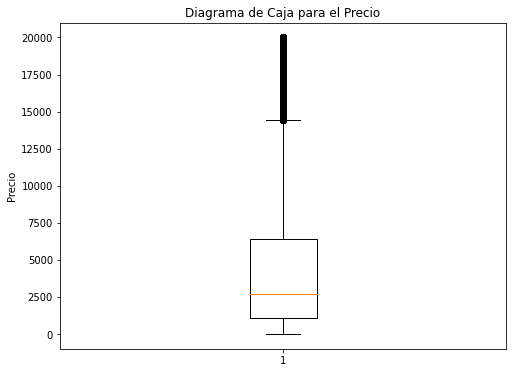

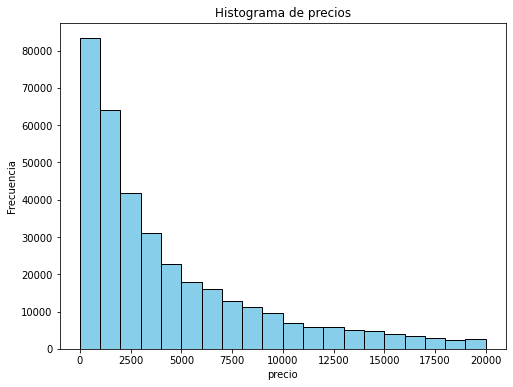

price                10772
vehicletype          10772
registrationyear     10772
gearbox              10772
power                10772
model                10772
mileage              10772
registrationmonth    10772
fueltype             10772
brand                10772
notrepaired          10772
numberofpictures     10772
postalcode           10772
datecrawled_year     10772
datecrawled_month    10772
datecrawled_day      10772
datecrawled_hour     10772
datecreated_year     10772
datecreated_month    10772
datecreated_day      10772
datecreated_hour     10772
lastseen_year        10772
lastseen_month       10772
lastseen_day         10772
lastseen_hour        10772
dtype: int64


In [8]:
plt.figure(figsize=(8, 6))
plt.boxplot(cardata['price'])
plt.title('Diagrama de Caja para el Precio')
plt.ylabel('Precio')
plt.show()

plt.figure(figsize=(8, 6))
plt.hist(cardata['price'], bins=20, color='skyblue', edgecolor='black')
plt.title('Histograma de precios')
plt.xlabel('precio')
plt.ylabel('Frecuencia')
plt.show()

minprices = cardata[(cardata['price'] == 0)]
print(minprices.count())

Debido a la alta cantidad de datos ingresados con un precio de 0, no se procederá a eliminarlos ya que una de las razones posibles sea que el auto este considerado como chatarra o debido a sus demás características, perdida total y como no se tiene mas información al respecto del porque hay tantos datos con esa información lo mas conveniente será dejarlos. 

### Gráficos para la columna de año de registro

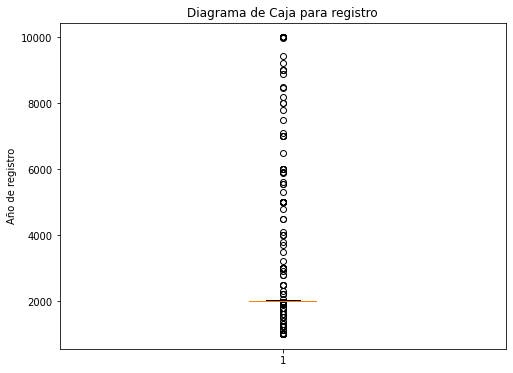

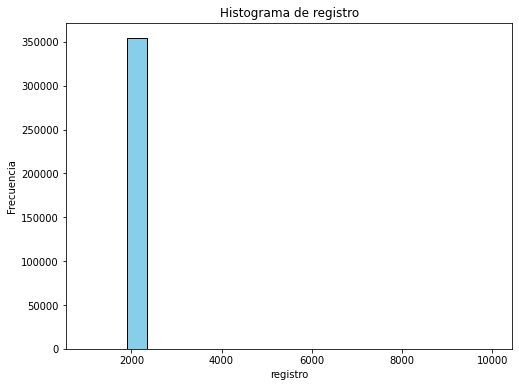

In [9]:
plt.figure(figsize=(8, 6))
plt.boxplot(cardata['registrationyear'])
plt.title('Diagrama de Caja para registro')
plt.ylabel('Año de registro')
plt.show()

plt.figure(figsize=(8, 6))
plt.hist(cardata['registrationyear'], bins=20,
         color='skyblue', edgecolor='black')
plt.title('Histograma de registro')
plt.xlabel('registro')
plt.ylabel('Frecuencia')
plt.show()

En las graficas se puede apreciar que la mayoría de los datos se encuentran dentro de un año razonable pero hay algunos extremos los cuales procederemos a eliminarlos por datos coherentes como menor al 2024 y mayores a 1950, año en el cual la empresa automotríz ya se encontraba en su apogeo comenzando a distribuir automóviles en masa, y aunque poco probable, hay posibilidad de obtener uno de estos todavía por lo que se pondra como mínimo en nuestro algoritmo. 

In [10]:
# Eliminación de datos atípicos
cardata = cardata[(cardata['registrationyear'] >= 1950) &
                  (cardata['registrationyear'] <= 2024)]

### Gráficos para la columna de año de potencia

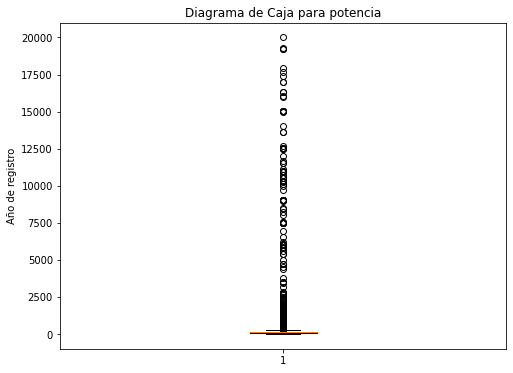

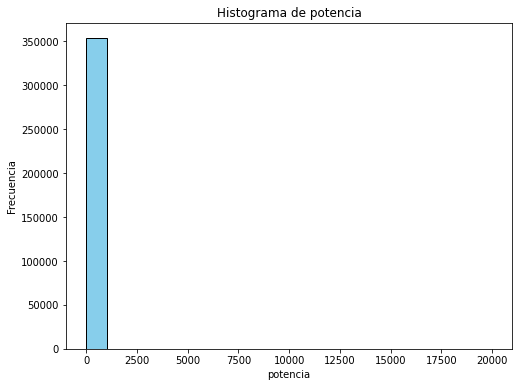

La cantidad de autos con potencias atípicas de más de 1800 son: 144


In [11]:
plt.figure(figsize=(8, 6))
plt.boxplot(cardata['power'])
plt.title('Diagrama de Caja para potencia')
plt.ylabel('Año de registro')
plt.show()

plt.figure(figsize=(8, 6))
plt.hist(cardata['power'], bins=20, color='skyblue', edgecolor='black')
plt.title('Histograma de potencia')
plt.xlabel('potencia')
plt.ylabel('Frecuencia')
plt.show()


print('La cantidad de autos con potencias atípicas de más de 1800 son:',
      (cardata['power'] > 1800).sum())

Se procederá con la eliminación de los datos atípicos:

In [12]:
cardata = cardata[(cardata['power'] < 1800)]

### Gráficos para la columna de mes de registro


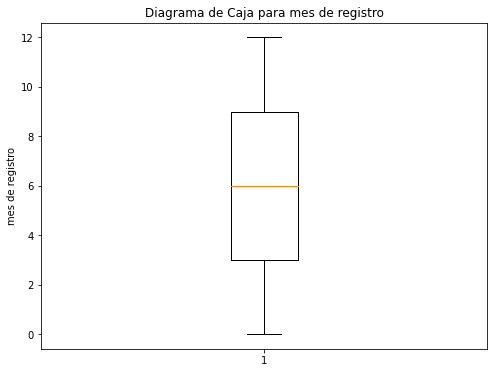

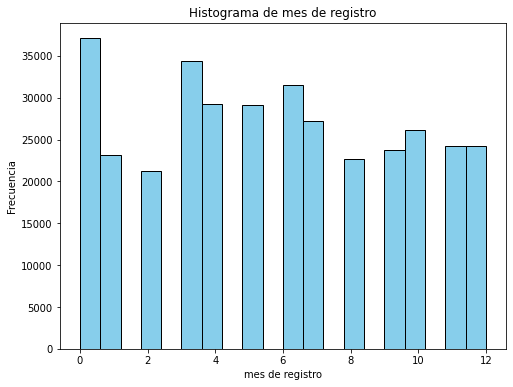

La cantidad de autos con registro en el mes 0 es de: 37104


In [13]:
plt.figure(figsize=(8, 6))
plt.boxplot(cardata['registrationmonth'])
plt.title('Diagrama de Caja para mes de registro')
plt.ylabel('mes de registro')
plt.show()

plt.figure(figsize=(8, 6))
plt.hist(cardata['registrationmonth'], bins=20,
         color='skyblue', edgecolor='black')
plt.title('Histograma de mes de registro')
plt.xlabel('mes de registro')
plt.ylabel('Frecuencia')
plt.show()

print('La cantidad de autos con registro en el mes 0 es de:',
      (cardata['registrationmonth'] == 0).sum())

### Resumen:

Para la columna de precios, debido a la alta cantidad de datos ingresados con un precio de 0, no se procederá a eliminarlos ya que una de las razones posibles sea que el auto este considerado como chatarra o debido a sus demás características, perdida total y como no se tiene mas información al respecto del porque hay tantos datos con esa información lo mas conveniente será dejarlos.

Para el año de registro, En las graficas se puede apreciar que la mayoría de los datos se encuentran dentro de un año razonable pero hay algunos extremos los cuales procederemos a eliminarlos por datos coherentes como menor al 2024 y mayores a 1950, año en el cual la empresa automotriz ya se encontraba en su apogeo comenzando a distribuir automóviles en masa, y aunque poco probable, hay posibilidad de obtener uno de estos todavía por lo que se filtrará como mínimo en nuestra base de datos. Seleccionar datos anteriores a esta fecha sería inadecuado si queremos mantener consistencia y calidad de datos, pues aunque si haya automóviles con fechas anteriores a 1950, no hay suficiente información confiable sobre ellos, por lo que se procede a excluir esos datos para mantener la coherencia en el conjunto de datos y es posible que los datos disponibles para los automóviles anteriores a 1950 sean menos confiables o estén incompletos. Al limitar el conjunto de datos a los años más recientes, se puede mejorar la calidad y la integridad de los datos utilizados en el análisis.

Se toma como un máximo una potencia de 1800 cv ya que pocos automóviles en el mundo cumplen con ésta característica y los cuales no se encuentran en esta tabla, tal es el caso del automóvil Lotus Evija que registro un cv de 1700 -1800 cv. lo que indica nuestro límite para el filtro de potencia. 

Debido a la gran cantidad de datos con registro 0 y sin haber mayores a 12 se consideran como 0 aquellos cuyo dato fue desconocido o faltante. De esta manera no se eliminarán ya que son el 10% de datos totales y se descarta un error en la entrada de datos.

Aquellos datos mencionados que fueron eliminados del dataset se consideran inadecuados por las razones expresadas en éste resumen y aquellos que no fue posible eliminarlos debido a su alta cantidad se tratarán como valores nulos para seguir adelante con el entrenamiento del algoritmo. 

## Entrenamiento del modelo 

In [14]:
# Division de df para entrenamiento y validación

features_train, features_valid, target_train, target_valid = train_test_split(
    cardata.drop('price', axis=1), cardata.price, test_size=0.25, random_state=12345)

# DF para algoritmos cuyas características categoricas necesiten codificacion OHE

cardata_OHE = pd.get_dummies(cardata, columns=[
                             'vehicletype', 'gearbox', 'model', 'fueltype', 'brand', 'notrepaired'])

features_train_ohe, features_valid_ohe, target_train_ohe, target_valid_ohe = train_test_split(
    cardata_OHE.drop('price', axis=1), cardata_OHE.price, test_size=0.25, random_state=12345)

### Entrenamiento con regresión lineal

In [15]:

modelR = LinearRegression()
%time modelR.fit(features_train_ohe, target_train_ohe)
predictions_trainR_ohe = modelR.predict(features_train_ohe)
result_trainR = mean_squared_error(target_train_ohe, predictions_trainR_ohe)**0.5
print("RMSE del modelo de regresión lineal en datos de entrenamiento:", result_trainR)
print()

%time predictions_validR_ohe = modelR.predict(features_valid_ohe)
resultR = mean_squared_error(target_valid_ohe, predictions_validR_ohe)**0.5


print("RECM del modelo de regresión lineal en datos de validación:", resultR)

CPU times: user 19.3 s, sys: 2.49 s, total: 21.8 s
Wall time: 21.8 s
RMSE del modelo de regresión lineal en datos de entrenamiento: 2760.076688646537

CPU times: user 98.3 ms, sys: 158 ms, total: 256 ms
Wall time: 290 ms
RECM del modelo de regresión lineal en datos de validación: 2774.2910142864584


### Entrenamiento con Potenciación del gradiente (gradient boosting) de la libreria lightGBM en un bosque aleatorio

**PRIMERA CONFIGURACION**

In [16]:

model_l = lgb.LGBMRegressor(boosting_type = 'rf', n_estimators = 150, learning_rate= 0.01,max_depth = 15, colsample_bytree = 0.8,bagging_freq=1,bagging_fraction=0.8, random_state = 12345)
%time model_l.fit(features_train_ohe, target_train_ohe)
predictions_train_l_ohe = model_l.predict(features_train_ohe)
result_train_l = mean_squared_error(target_train_ohe, predictions_train_l_ohe)**0.5
print("RMSE del modelo en datos de entrenamiento:", result_train_l)
print()


%time predictions_valid_l = model_l.predict(features_valid_ohe)
result_l = mean_squared_error(target_valid_ohe, predictions_valid_l)**0.5

print("RECM del modelo de bosque aleatorio en lightGBM en validación :", result_l)

[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
CPU times: user 14.2 s, sys: 302 ms, total: 14.5 s
Wall time: 14.6 s
RMSE del modelo en datos de entrenamiento: 2349.0085135701192

CPU times: user 1.22 s, sys: 58.3 ms, total: 1.27 s
Wall time: 1.23 s
RECM del modelo de bosque aleatorio en lightGBM en validación : 2341.8409418091874


**SEGUNDA CONFIGURACION**

In [17]:

model_l = lgb.LGBMRegressor(boosting_type = 'rf', n_estimators = 200, learning_rate= 0.01,max_depth = 20, colsample_bytree = 0.9,bagging_freq=1,bagging_fraction=0.8, random_state = 12345)
%time model_l.fit(features_train_ohe, target_train_ohe)
predictions_train_l_ohe = model_l.predict(features_train_ohe)
result_train_l = mean_squared_error(target_train_ohe, predictions_train_l_ohe)**0.5
print("RMSE del modelo en datos de entrenamiento:", result_train_l)
print()

%time predictions_valid_l = model_l.predict(features_valid_ohe)
result_l = mean_squared_error(target_valid_ohe, predictions_valid_l)**0.5

print("RECM del modelo de bosque aleatorio en lightGBM :", result_l)

[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
CPU times: user 18 s, sys: 232 ms, total: 18.3 s
Wall time: 18.3 s
RMSE del modelo en datos de entrenamiento: 2368.9080782400893

CPU times: user 1.47 s, sys: 66.6 ms, total: 1.53 s
Wall time: 1.57 s
RECM del modelo de bosque aleatorio en lightGBM : 2359.759436045047


### Entrenamiento con Potenciación del gradiente (gradient boosting) de la libreria lightGBM en un árbol de decisiones.

**PRIMERA CONFIGURACION**

In [18]:

model_tree_l = lgb.LGBMRegressor(boosting_type='gbdt', num_leaves=31, max_depth=10, learning_rate=0.1, random_state=12345)
%time model_tree_l.fit(features_train_ohe, target_train_ohe)
predictions_train_tree_l_ohe = model_tree_l.predict(features_train_ohe)
result_train_tree_l = mean_squared_error(target_train_ohe, predictions_train_tree_l_ohe)**0.5
print("RMSE del modelo en datos de entrenamiento:", result_train_tree_l)
print()

%time predictions_valid_tree_l = model_tree_l.predict(features_valid_ohe)
result_tree_l = mean_squared_error(target_valid_ohe, predictions_valid_tree_l)**0.5

print("RECM del modelo de árbol de decisiones en LightGBM:", result_tree_l)


CPU times: user 1min 11s, sys: 759 ms, total: 1min 11s
Wall time: 1min 12s
RMSE del modelo en datos de entrenamiento: 1790.6129572786049

CPU times: user 1.07 s, sys: 52.2 ms, total: 1.12 s
Wall time: 1.11 s
RECM del modelo de árbol de decisiones en LightGBM: 1800.0636993529026


**SEGUNDA CONFIGURACION**

In [19]:

model_tree_l = lgb.LGBMRegressor(boosting_type='gbdt', num_leaves=40, max_depth=20, learning_rate=0.1, random_state=12345)
%time model_tree_l.fit(features_train_ohe, target_train_ohe)
predictions_train_tree_l_ohe = model_tree_l.predict(features_train_ohe)
result_train_tree_l = mean_squared_error(target_train_ohe, predictions_train_tree_l_ohe)**0.5
print("RMSE del modelo en datos de entrenamiento:", result_train_tree_l)
print()

%time predictions_valid_tree_l = model_tree_l.predict(features_valid_ohe)
result_tree_l = mean_squared_error(target_valid_ohe, predictions_valid_tree_l)**0.5

print("RECM del modelo de árbol de decisiones en LightGBM:", result_tree_l)

CPU times: user 1min 49s, sys: 958 ms, total: 1min 50s
Wall time: 1min 51s
RMSE del modelo en datos de entrenamiento: 1751.4123250409384

CPU times: user 1.19 s, sys: 81.1 ms, total: 1.27 s
Wall time: 1.28 s
RECM del modelo de árbol de decisiones en LightGBM: 1767.9463947667869


### Entrenamiento con Potenciación del gradiente (gradient boosting) de la libreria CATboost

**PRIMERA CONFIGURACION**

In [20]:

cat_features = [
    'vehicletype',
    'gearbox',
    'model',
    'fueltype',
    'brand',
    'notrepaired',
]

model_cat = CatBoostRegressor(iterations=150, learning_rate=0.1, depth=6, random_seed=12345)
%time model_cat.fit(features_train, target_train, cat_features=cat_features, early_stopping_rounds=10, verbose=10)
predictions_train_cat = model_cat.predict(features_train)
result_train_cat = mean_squared_error(target_train, predictions_train_cat)**0.5
print("RMSE del modelo en datos de entrenamiento:", result_train_cat)
print()

%time predictions_valid_cat = model_cat.predict(features_valid)
result_cat = mean_squared_error(target_valid, predictions_valid_cat) ** 0.5

print("RECM del modelo de bosque aleatorio en CatBoost:", result_cat)


0:	learn: 4230.0209105	total: 336ms	remaining: 50s
10:	learn: 2768.7084674	total: 3s	remaining: 37.9s
20:	learn: 2304.5715722	total: 5.62s	remaining: 34.5s
30:	learn: 2129.3067577	total: 8.26s	remaining: 31.7s
40:	learn: 2055.3952901	total: 10.8s	remaining: 28.6s
50:	learn: 2011.8238574	total: 13.3s	remaining: 25.8s
60:	learn: 1981.3775058	total: 15.8s	remaining: 23.1s
70:	learn: 1959.6582221	total: 18.4s	remaining: 20.5s
80:	learn: 1930.9364032	total: 20.9s	remaining: 17.8s
90:	learn: 1912.0098256	total: 23.5s	remaining: 15.2s
100:	learn: 1897.5020119	total: 26s	remaining: 12.6s
110:	learn: 1886.7442053	total: 28.5s	remaining: 10s
120:	learn: 1874.5859539	total: 31.1s	remaining: 7.45s
130:	learn: 1864.5220052	total: 33.6s	remaining: 4.87s
140:	learn: 1853.9316938	total: 36.1s	remaining: 2.31s
149:	learn: 1846.2086719	total: 38.4s	remaining: 0us
CPU times: user 38.9 s, sys: 102 ms, total: 39 s
Wall time: 39.4 s
RMSE del modelo en datos de entrenamiento: 1841.2396969291751

CPU times: u

**SEGUNDA CONFIGURACION**

In [21]:

model_cat = CatBoostRegressor(iterations=200, learning_rate=0.1, depth=8, random_seed=12345)
%time model_cat.fit(features_train, target_train, cat_features=cat_features, early_stopping_rounds=10, verbose=10)
predictions_train_tree_cat = model_cat.predict(features_train)
result_train_cat = mean_squared_error(target_train, predictions_train_cat)**0.5
print("RMSE del modelo en datos de entrenamiento:", result_train_cat)
print()

%time predictions_valid_cat = model_cat.predict(features_valid)
result_cat = mean_squared_error(target_valid, predictions_valid_cat) ** 0.5

print("RECM del modelo de bosque aleatorio en CatBoost:", result_cat)


0:	learn: 4211.7761274	total: 971ms	remaining: 3m 13s
10:	learn: 2626.2136888	total: 9.54s	remaining: 2m 43s
20:	learn: 2158.7679397	total: 17.6s	remaining: 2m 29s
30:	learn: 2010.6021306	total: 26s	remaining: 2m 21s
40:	learn: 1946.6493996	total: 34.1s	remaining: 2m 12s
50:	learn: 1911.9445137	total: 41.9s	remaining: 2m 2s
60:	learn: 1885.4786504	total: 49.9s	remaining: 1m 53s
70:	learn: 1859.9392589	total: 57.7s	remaining: 1m 44s
80:	learn: 1840.2608897	total: 1m 5s	remaining: 1m 36s
90:	learn: 1823.9619596	total: 1m 13s	remaining: 1m 28s
100:	learn: 1810.0381867	total: 1m 22s	remaining: 1m 20s
110:	learn: 1796.4428818	total: 1m 30s	remaining: 1m 12s
120:	learn: 1784.8684944	total: 1m 38s	remaining: 1m 4s
130:	learn: 1774.6507549	total: 1m 46s	remaining: 56.1s
140:	learn: 1765.5869885	total: 1m 55s	remaining: 48.2s
150:	learn: 1756.1508645	total: 2m 3s	remaining: 39.9s
160:	learn: 1746.9337469	total: 2m 11s	remaining: 31.7s
170:	learn: 1738.6900690	total: 2m 19s	remaining: 23.7s
180:

### Entrenamiento con Potenciación del gradiente (gradient boosting) de la libreria XGBoost en un bosque 

**PRIMERA CONFIGURACION**


In [22]:
model_xgb = XGBRegressor(n_estimators=50, learning_rate=0.3, max_depth=4, subsample=0.8, random_state=12345)
%time model_xgb.fit(features_train_ohe, target_train_ohe)
predictions_train_xgb = model_xgb.predict(features_train_ohe)
result_train_xgb = mean_squared_error(target_train_ohe, predictions_train_xgb)**0.5
print("RMSE del modelo en datos de entrenamiento:", result_train_xgb)
print()

%time predictions_valid_xgb = model_xgb.predict(features_valid_ohe)
result_xgb = mean_squared_error(target_valid_ohe, predictions_valid_xgb)**0.5
print("RECM del modelo XGBoost:", result_xgb)


CPU times: user 3min 26s, sys: 792 ms, total: 3min 27s
Wall time: 3min 27s
RMSE del modelo en datos de entrenamiento: 1897.4633341479664

CPU times: user 1.05 s, sys: 44 ms, total: 1.09 s
Wall time: 1.05 s
RECM del modelo XGBoost: 1898.958775467307


**SEGUNDA CONFIGURACION**

In [23]:

model_xgb = XGBRegressor(n_estimators=60, learning_rate=0.3, max_depth=5, subsample=0.8, random_state=12345)
%time model_xgb.fit(features_train_ohe, target_train_ohe)
predictions_train_xgb = model_xgb.predict(features_train_ohe)
result_train_xgb = mean_squared_error(target_train_ohe, predictions_train_xgb)**0.5
print("RMSE del modelo en datos de entrenamiento:", result_train_xgb)
print()

%time predictions_valid_xgb = model_xgb.predict(features_valid_ohe)
result_xgb = mean_squared_error(target_valid_ohe, predictions_valid_xgb)**0.5
print("RECM del modelo XGBoost:", result_xgb)

CPU times: user 5min 8s, sys: 1 s, total: 5min 9s
Wall time: 5min 9s
RMSE del modelo en datos de entrenamiento: 1803.9751961905592

CPU times: user 1.12 s, sys: 31.9 ms, total: 1.15 s
Wall time: 1.16 s
RECM del modelo XGBoost: 1829.7032580209445


## Análisis de los modelos


| Hiperparámetros| Modelo|Librería|Tiempo en entrenamiento (s)|Tiempo en predicción (s)|RMSE en entrenamiento|RMSE en predicción|
|:---------------|:-----:|:------:|:---------------------:|:------------------:|:-------------------:|:----------------:|
| Configuración general |Regresión lineal|scikit-learn| 21.8  | 0.290  | 2760.07 |2774.29 |
| 1er Configuración|Bosque aleatorio |lightGBM| 14.6 | 1.23  | 2349 |2341.84|
| 2da Configuración|Bosque aleatorio |lightGBM| 18.3 | 1.57 | 2368.90 |2359.75|
| 1er Configuración|Árbol de decisiones |lightGBM| 72| 1.11  | 1790.61 |1800.06|
| 2da Configuración|Árbol de decisiones |lightGBM| 111 | 1.28  | 1751.41 |1767.94|
| 1er Configuración|Bosque aleatorio |CATboost| 39.4| 0.152 | 1841.23 |1839.65|
| 2da Configuración|Bosque aleatorio |CATboost| 164 | 0.353  | 1841.23 |1742.85|
| 1er Configuración|Gradient boosting tree |XGBoost| 207 | 1.05 | 1897.46 |1898.95|
| 2da Configuración|Gradient boosting tree |XGBoost| 309 | 1.16 | 1803.97 |1829.70|

Basándonos en la calidad de los modelos seleccionados, encontramos que el mejor desempeño proviene del bosque aleatorio de CatBoost, con un RMSE de 1742.85 y tiempos de predicción en milisegundos. Aunque LightGBM también presentó buenos resultados, el bosque aleatorio de CatBoost superó ligeramente en calidad.

El equilibrio entre tiempo y calidad ofrecido por el bosque aleatorio de CatBoost lo convierte en una excelente opción. Aunque el árbol de decisiones de LightGBM también ofreció buenos resultados, su rendimiento fue ligeramente inferior en comparación con el bosque aleatorio de CatBoost y la velocidad de entrenamiento menor. 

Dado que las predicciones del modelo difieren del valor real en alrededor de 1742 unidades de la variable objetivo, en este caso, un RMSE de 1742 indica un buen rendimiento del modelo.

<div class="alert alert-block alert-success">
    
# Comentarios generales
<b>Comentario del revisor</b> <a class="tocSkip"></a>
    
Has aprobado un nuevo proyecto. ¡Felicitaciones!
</div>